# What is Logistic Regression?

## Introduction

Logistic Regression is a machine learning technique that is used to predict binary dependent variables. Given a set of training data, it will fit the sigmoid function to the data by fiting coefficients of the input data. When the new fitted function is applied to testing data, the output will be a number from 0-1 representing the model's confidence that the traiing data is classified as 0 or 1. If the number is greater than 0.5 then the model predicts that the training datum is in class 1. Otherwise, it predicts the training datum is in class 0.

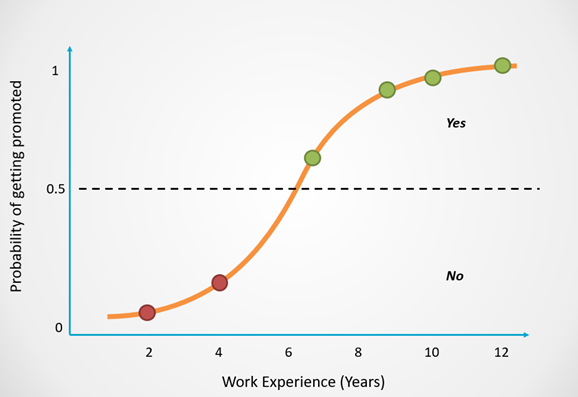

## Sigmoid Function


The sigmoid function is defined:
$$ y = \frac{1}{1+e^{-(wx+b)}}$$

where w is are the learned weights, b are the bias term,  x is the input variable, and y is the output probability.

The output of this function when applied to training will be a probability. For example, we may input some data about weather, and y is a binary variable 1 if Maciej will go on a run, 0 otherwise. If the model outputs 0.1, this means that it predicts Maciej will not go on a run and in fact he only has a 10% chance that he will go on a run. The model will likewise predict that Maciej will not go on a run if on a new piece of datum it outputs y = 0.3. However, the model is more certain when y = 0.1 than when y = 0.3.

# Implementing Logistic Regression on Movie Data

## Task

When a movie is released, production companies would like to know whether people will like their movie. This is important to improve the reputation of the production company as well as satisfying loyal fans. It is far too costly to fully make a movie and then survey people whether they like the movie or not. It would be far preferred if a production company could predict whether or not audiences will think their movie is good depending on data about the movie.

To accomplish this task, quantify whether an audience liked a movie by using IMBD score. If IMBD score is greater than 7, then the movie is considered good. If it is lower than 7, then the movie is considered not good.

##  Data Exploration

The data set has the following columns:

- **name**: The title of the movie.
- **rating**: The movie's content rating (e.g., PG, R).
- **genre**: The genre of the movie (e.g., Drama, Adventure, Comedy).
- **year**: The year the movie was released.
- **released**: The release date of the movie, including the country of release.
- **score**: The IMDb score (rating) of the movie.
- **votes**: The number of votes the movie has received on IMDb.
- **director**: The director of the movie.
- **writer**: The writer or writers of the movie.
- **star**: The main star or actor featured in the movie.
- **country**: The country where the movie was produced.
- **budget**: The production budget of the movie (in USD).
- **gross**: The total box office gross of the movie (in USD).
- **company**: The production company behind the movie.
- **runtime**: The runtime of the movie in minutes.

In [1]:
import pandas as pd

filename = r"C:\Users\pjs5\Downloads\movies.csv"
df = pd.read_csv(filename)

df['high_score'] = df['score'].apply(lambda x: 1 if x >= 7 else 0)

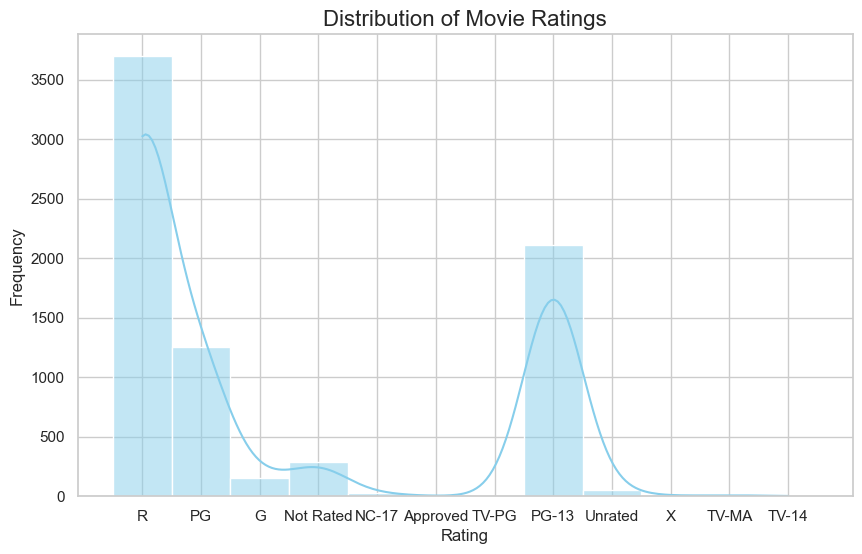

C:\Users\pjs5\AppData\Local\Temp\ipykernel_18044\463088873.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.index, y=top_genres.values, palette='viridis')


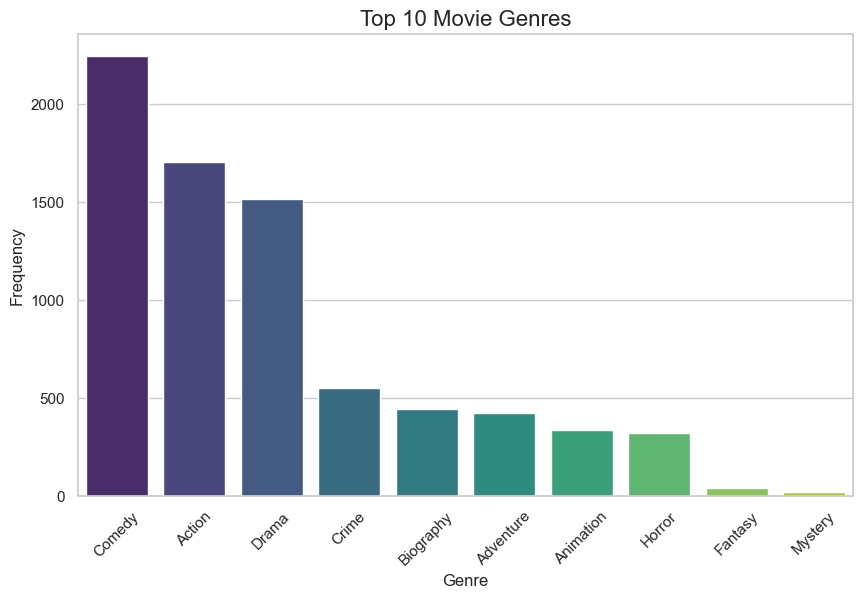

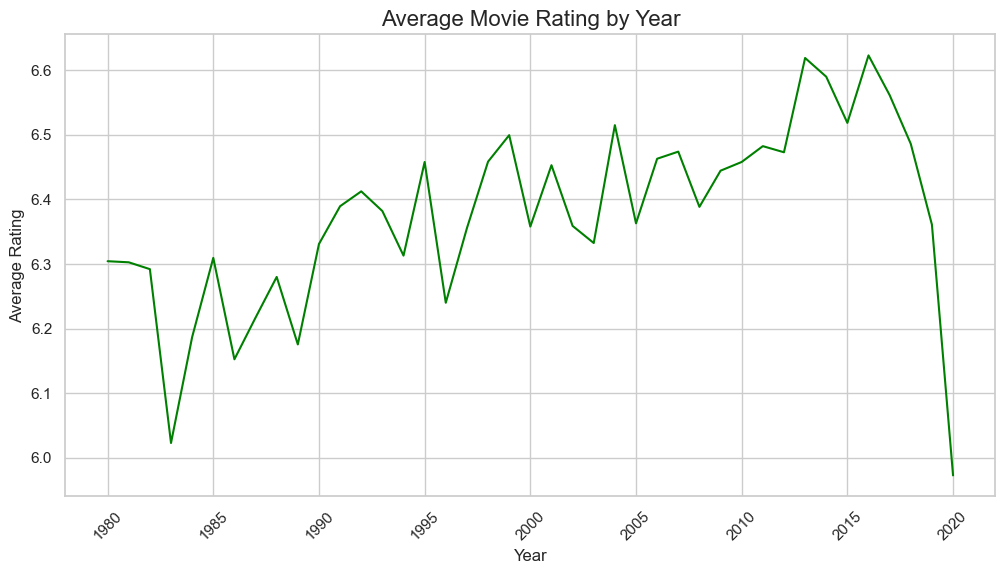

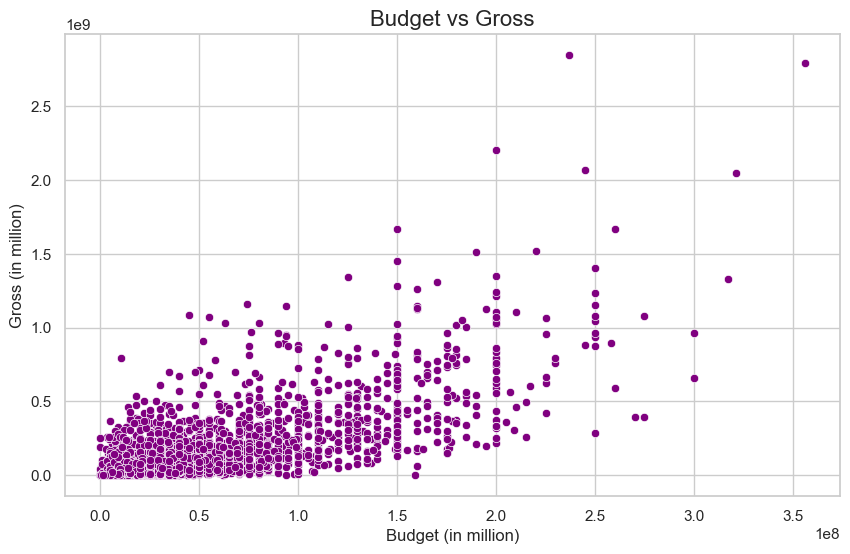

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Distribution of Movie Ratings
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Movie Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# 2. Top 10 Genres by Frequency
top_genres = df['genre'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_genres.index, y=top_genres.values, palette='viridis')
plt.title('Top 10 Movie Genres', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# 3. Average Rating by Year
avg_rating_year = df.groupby('year')['score'].mean().sort_index(ascending=True)
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_rating_year.index, y=avg_rating_year.values, color='green')
plt.title('Average Movie Rating by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45)
plt.show()


# 4. Budget vs. Gross
df_clean = df.dropna(subset=['budget', 'gross'])

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_clean['budget'], y=df_clean['gross'], color='purple')
plt.title('Budget vs Gross', fontsize=16)
plt.xlabel('Budget (in million)', fontsize=12)
plt.ylabel('Gross (in million)', fontsize=12)
plt.show()

Here we see some trends regarding movies. The most common rating for a movie in this dataset is rated R and the most common genre is comedy.The average movie rating appears to be on an upward trend from 1980 to 2015, but there is a downward trend from 2015 to 2020. Lastly, there seems to be a positive correlation between a movies budget and its revenue.  

## Implementing Logistic Regression

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


df_clean = df.dropna()

categorical_columns = ['genre', 'director', 'writer', 'star', 'country', 'company']  # Modify if needed
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    df_clean[column] = le.fit_transform(df_clean[column].astype(str))
    label_encoders[column] = le

desired_order = [ 'G', 'PG', 'PG-13', 'R', 'TV-MA', 'X']

df_clean = df_clean[df_clean['rating'].isin(desired_order)].copy()

rating_encoder = LabelEncoder()

rating_encoder.fit(desired_order)
df_clean['rating'] = rating_encoder.transform(df_clean['rating'])

label_encoders['rating'] = rating_encoder

learned_order = list(rating_encoder.classes_)

print(f"Order learned by LabelEncoder: {learned_order}")
print(f"Desired order specified:      {desired_order}")

scaler = StandardScaler()
numerical_columns = ['year', 'score', 'votes', 'budget', 'gross', 'runtime']
df_clean[numerical_columns] = scaler.fit_transform(df_clean[numerical_columns])

X = df_clean.drop(['name', 'high_score', 'released', 'score', 'votes', 'gross'], axis=1)  # Features: all columns except 'name' and 'high_score'
y = df_clean['high_score']  # Target: 'high_score' column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

C:\Users\pjs5\AppData\Local\Temp\ipykernel_18044\227152733.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[column] = le.fit_transform(df_clean[column].astype(str))
C:\Users\pjs5\AppData\Local\Temp\ipykernel_18044\227152733.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[column] = le.fit_transform(df_clean[column].astype(str))
C:\Users\pjs5\AppData\Local\Temp\ipykernel_18044\227152733.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Order learned by LabelEncoder: [np.str_('G'), np.str_('PG'), np.str_('PG-13'), np.str_('R'), np.str_('TV-MA'), np.str_('X')]
Desired order specified:      ['G', 'PG', 'PG-13', 'R', 'TV-MA', 'X']


c:\Program Files\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Evaluating The Model

Accuracy: 0.7486


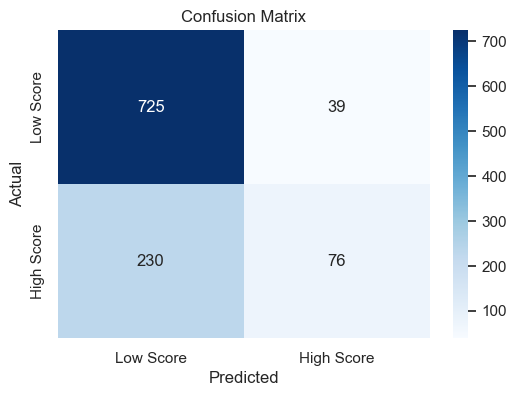

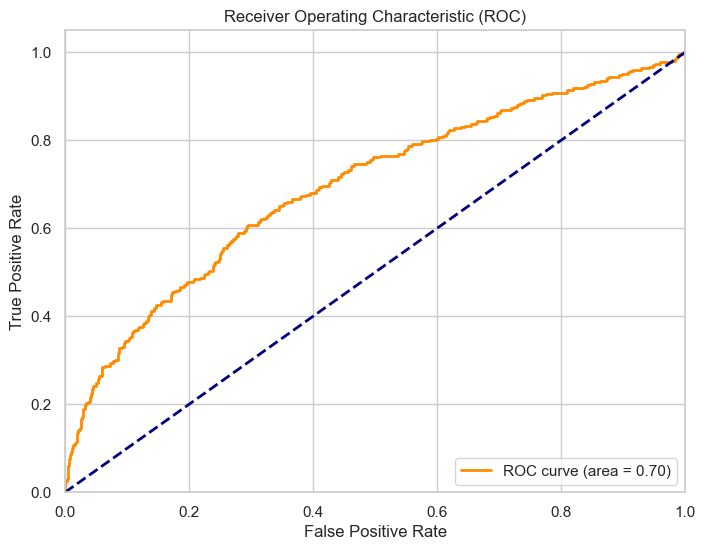

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Score', 'High Score'], yticklabels=['Low Score', 'High Score'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### Model Coefficients

C:\Users\pjs5\AppData\Local\Temp\ipykernel_18044\1896131478.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')


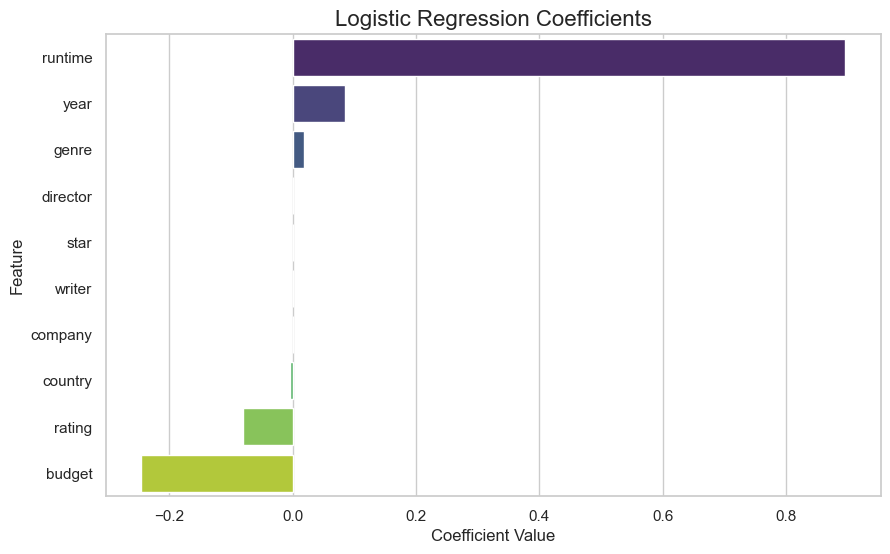

In [ ]:
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')
plt.title('Logistic Regression Coefficients', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()


## Results

The confusion matrix shows that the logistic regression model performs well for predicting whether a movie will have an IMDB score of less 7 but struggles when predicting whether a movie will have a score higher than 7. This implies that bad movies have certain shared characteristics of the given input data in this dataset, but good movies are less predictable.

The coefficient graph suggests that the more mature a movie is (X being the most mature), the lower its probability of being a good movie. Another factor is budget, where a higher budget actually predicts a lower probability of being a good movie.

It is initially surprising that higher budget movies are less probable of being good because one would assume that higher budgets would allow for higher quality sets, better actors, more famous directors, etc. However, the result of the model could be interpreted by the fact that there are many highly acclaimed movie with low budgets such as... Movies with smaller budgets may allow for directors to have more creative freedom because they are not attached to massive contracts. This could allow them to make better movies despite the lower budget. It is interesting to note that higher gross is correlated with higher budgets. This means that although higher budget movies may be worse, people are still watching them in higher numbers. This could be due to greater marketing of these high budget movies.

## Logistic Regression From Scratch

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

class ScratchLogisticRegression:
    def __init__(self, alpha, epochs):
        self.alpha = alpha
        self.epochs = epochs

    def train(self, features, labels):
        self.samples, self.features_count = features.shape
        self.weights = np.zeros(self.features_count)
        self.bias = 0
        self.X = features
        self.Y = labels

        for _ in range(self.epochs):
            self._gradient_descent()

        return self

    def _gradient_descent(self):
        linear_model = np.dot(self.X, self.weights) + self.bias

        predictions = 1 / (1 + np.exp(-1 * linear_model))

        errors = predictions - self.Y.reshape(-1)
        dw = np.dot(self.X.T, errors) / self.samples
        db = np.sum(errors) / self.samples

        self.weights -= self.alpha * dw
        self.bias -= self.alpha * db

    # Predict class labels
    def predict(self, inputs):
        linear_output = np.dot(inputs, self.weights) + self.bias
        probabilities = 1 / (1 + np.exp(-linear_output))
        return np.where(probabilities > 0.5, 1, 0)

def main():
    df = pd.read_csv(r"C:\Users\peter\Downloads\archive (4)\diabetes_dataset_with_notes.csv")
    df = df.drop(columns=['year', 'clinical_notes'])
    df = pd.get_dummies(df, drop_first=True)

    X = df.drop(columns=['diabetes'])
    y = df['diabetes']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10, random_state=0)

    custom_model = ScratchLogisticRegression(alpha=0.01, epochs=1000)
    custom_model.train(X_train.values, y_train.values)

    sklearn_model = LogisticRegression()
    sklearn_model.fit(X_train, y_train)

    custom_predictions = custom_model.predict(X_test.values)
    sklearn_predictions = sklearn_model.predict(X_test)

    custom_accuracy = np.mean(custom_predictions == y_test.values) * 100
    sklearn_accuracy = np.mean(sklearn_predictions == y_test.values) * 100

    print(f"Custom model accuracy on test data   : {custom_accuracy:.2f}%")
    print(f"Sklearn model accuracy on test data  : {sklearn_accuracy:.2f}%")

if __name__ == "__main__":
    main()